In [ ]:
import numpy as np
import pandas as pd
import spacy 
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import random
import re
import unicodedata
import string

In [114]:
ls ./data

test.csv*  train.csv*


## Train Data

In [147]:
df_train = pd.read_csv('./data/raw/train.csv')

In [148]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [24]:
df_train.isna().sum()/len(df_train)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

<AxesSubplot:>

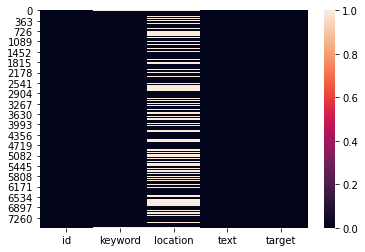

In [25]:
sns.heatmap(df_train.isnull())

In [26]:
df_train = df_train.fillna('unk')

In [27]:
cols = ['text', 'target', 'keyword', 'location']
print('There are {duplicated} duplicated record'.format(duplicated = df_train.duplicated(subset = cols).sum()))

There are 52 duplicated record


In [28]:
#delete repeated entries
df_train = df_train.drop_duplicates(cols).reset_index(drop = True)

In [29]:
dup_tweets = df_train[df_train.duplicated(subset = 'text',keep=False)].sort_values(by='text')
print('Number of duplicate tweets is {}'.format(len(dup_tweets)))
dup_tweets = dup_tweets.groupby(['text']).agg({
    'id':'count',
    'keyword': 'nunique',
    'target': 'nunique',
    'location': 'nunique',
}).reset_index().rename(columns = {'id': 'text_dup_times'})
dup_tweets['#duplicates'] = dup_tweets['text_dup_times']
dup_tweets.groupby('text_dup_times').agg({
    '#duplicates' : 'count',
    'keyword': 'sum',
    'target': 'sum',
    'location': 'sum',
}).reset_index()

Number of duplicate tweets is 106


,text_dup_times,#duplicates,keyword,target,location
0,2,40,63,53,51
1,3,7,7,12,20
2,5,1,1,1,5


In [30]:
df_train = df_train.groupby(by = ['text']).agg({
    'id': 'first',
    'location': lambda x:x.value_counts().index[0],
    'keyword':lambda x:x.value_counts().index[0],
    'target': lambda x:x.value_counts().index[0],
}).reset_index()

<AxesSubplot:xlabel='length', ylabel='Count'>

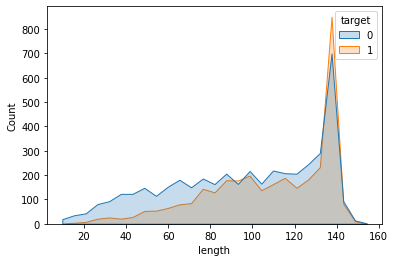

In [129]:
temp = pd.DataFrame(zip(df_train.text.str.len(),df_train.target),columns=['length','target'])
sns.histplot(x= temp.length, hue =temp.target  ,element="poly")

target distribution


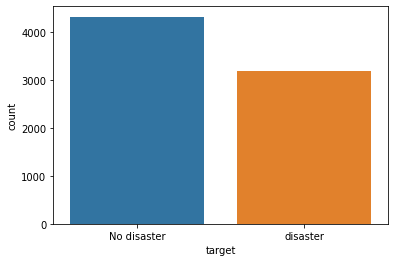

In [32]:
print('target distribution')
labels = ['No disaster','disaster']
ax = sns.countplot(x ='target', data = df_train)
ax.set_xticklabels(labels)
plt.show()

In [33]:
df_train.keyword.value_counts()[:15]

unk            56
fatalities     45
deluge         42
armageddon     42
damage         41
body%20bags    41
harm           41
evacuate       40
siren          40
twister        40
fear           40
windstorm      40
sinkhole       39
whirlwind      39
sunk           39
Name: keyword, dtype: int64

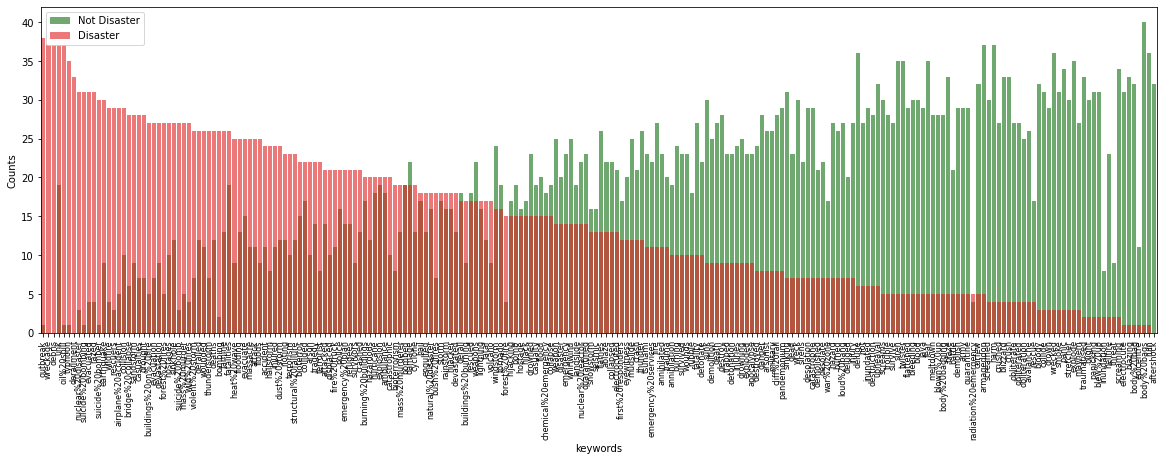

In [34]:
df = pd.pivot_table(df_train, index = ['keyword'], columns = ['target'], values = 'id', aggfunc = 'count', fill_value = 0 ).reset_index()
df = df.sort_values(by = [1], ascending = False)
plt.figure(figsize = (20, 6))
sns.barplot(y = 0, x = 'keyword', data = df, color = "g", alpha = 0.6, label = 'Not Disaster')
sns.barplot(y = 1, x = 'keyword', data = df, color = 'r', alpha = 0.6, label = 'Disaster')
plt.xlabel('keywords')
plt.ylabel('Counts')
plt.xticks(rotation = 90, fontsize = 8)
plt.legend()

In [35]:
df_train['location'].value_counts()[0:20]

unk                2479
USA                 104
New York             71
United States        50
London               45
Canada               29
UK                   27
Los Angeles, CA      26
Nigeria              23
India                22
Washington, DC       21
Kenya                20
Mumbai               20
Worldwide            19
Australia            18
Chicago, IL          18
California           17
New York, NY         15
California, USA      15
Everywhere           15
Name: location, dtype: int64

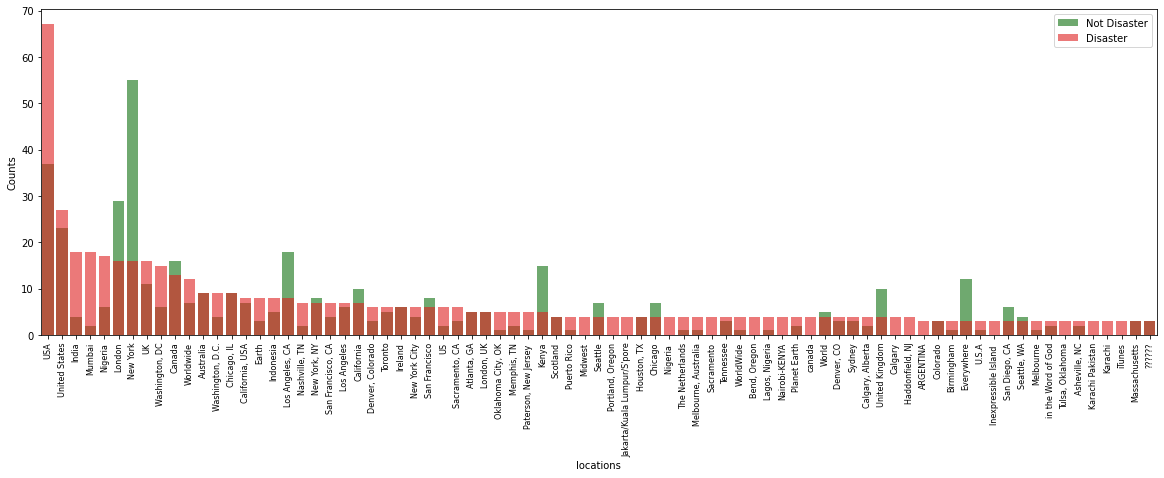

In [36]:
df = pd.pivot_table(df_train, index = ['location'], columns = ['target'], values = 'id', aggfunc = 'count', fill_value = 0 ).reset_index()
df = df.sort_values(by = 1, ascending = False)
lim = 80

plt.figure(figsize = (20, 6))
sns.barplot(y = 0, x = 'location', data = df.iloc[1:lim], color = "g", alpha = 0.6, label = 'Not Disaster')
sns.barplot(y = 1, x = 'location', data = df.iloc[1:lim], color = 'r', alpha = 0.6, label = 'Disaster')
plt.xlabel('locations')
plt.ylabel('Counts')
plt.xticks(rotation = 90, fontsize = 8)
plt.legend()

<AxesSubplot:xlabel='word_count', ylabel='Count'>

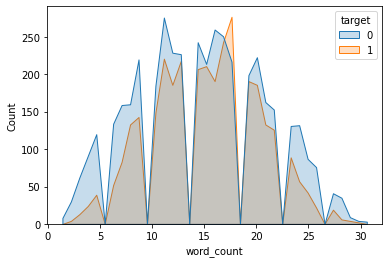

In [131]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
sns.histplot(data = df_train,x = 'word_count',hue='target',element="poly")


<AxesSubplot:xlabel='unique_word_count', ylabel='Count'>

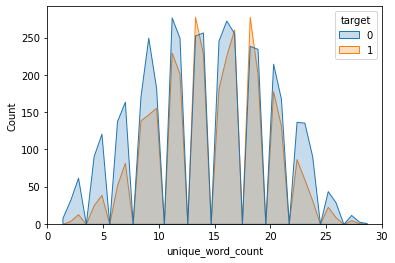

In [132]:
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
sns.histplot(data = df_train,x = 'unique_word_count',hue='target',element="poly")

<AxesSubplot:xlabel='mean_word_length', ylabel='Count'>

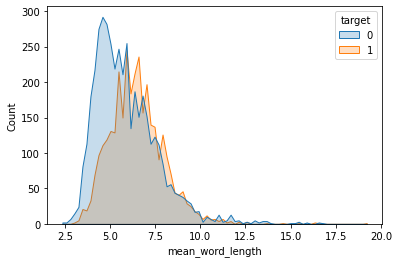

In [133]:
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
sns.histplot(data = df_train,x = 'mean_word_length',hue='target',element="poly")

<AxesSubplot:xlabel='char_count', ylabel='Count'>

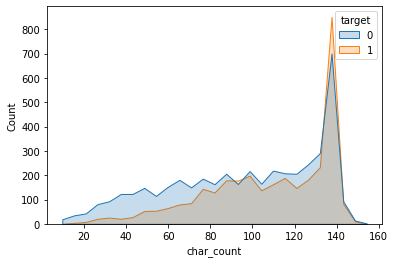

In [134]:
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
sns.histplot(data = df_train,x = 'char_count',hue='target',element="poly")

<AxesSubplot:xlabel='punctuation_count', ylabel='Count'>

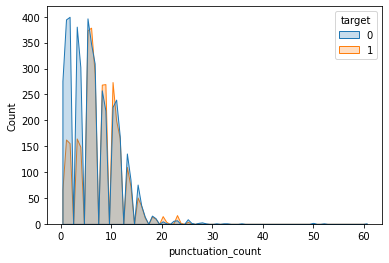

In [139]:
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
sns.histplot(data = df_train,x = 'punctuation_count',hue='target',element="poly")

<AxesSubplot:xlabel='url_count', ylabel='Count'>

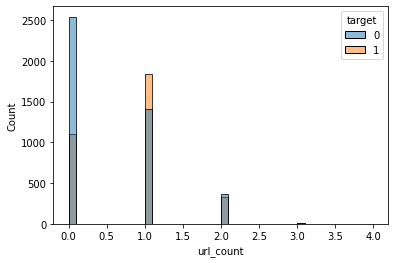

In [146]:
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
sns.histplot(data = df_train,x = 'url_count',hue='target')

<AxesSubplot:xlabel='hashtag_count', ylabel='Count'>

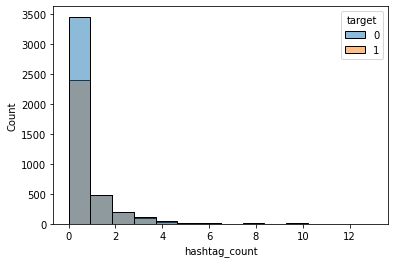

In [141]:
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
sns.histplot(data = df_train,x = 'hashtag_count',hue='target')

<AxesSubplot:xlabel='mention_count', ylabel='Count'>

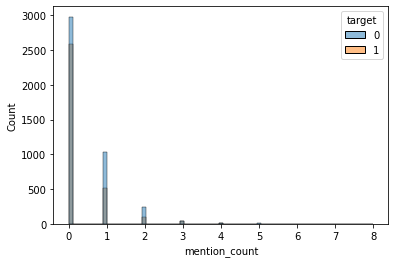

In [144]:
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
sns.histplot(data = df_train,x = 'mention_count',hue='target')